Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

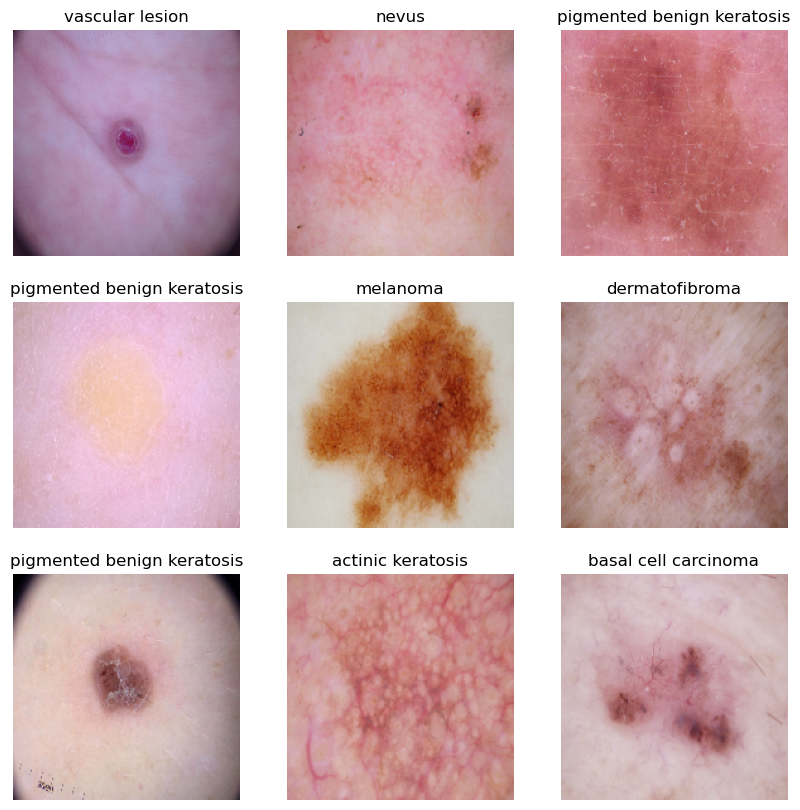

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [11]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 178, 178, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 176, 176, 32)      9248      
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 88, 88, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 86, 86, 64)        18496     
 apper)                                                 

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 173s 3s/step - loss: -59741.7148 - accuracy: 0.1719 - val_loss: -58287.1172 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 149s 3s/step - loss: -761269.9375 - accuracy: 0.1724 - val_loss: -798984.5625 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 151s 3s/step - loss: -2965127.7500 - accuracy: 0.1724 - val_loss: -3587483.5000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 155s 3s/step - loss: -7404118.5000 - accuracy: 0.1724 - val_loss: -9723237.0000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 94s 2s/step - loss: -14783670.0000 - accuracy: 0.1724 - val_loss: -19637588.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 105s 2s/step - loss: -25746972.0000 - accuracy: 0.1724 - val_loss: -28152318.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 93s 2s/step - loss: -

### Visualizing training results

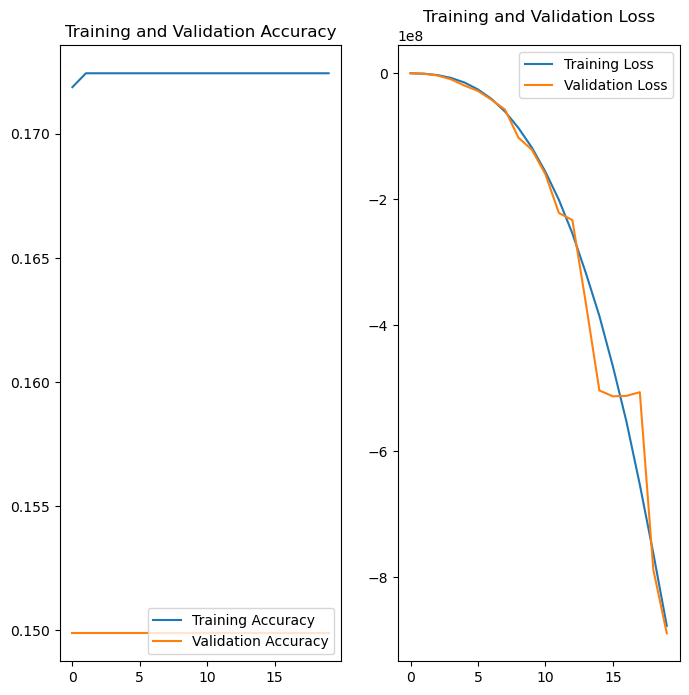

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- Model seems to be underfit 
- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model underfit and we need to chose right data augumentation strategy

14/14 [==============================] - 4s 270ms/step - loss: -889022592.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -867094720.0
Validation Loss -889022592.0


In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


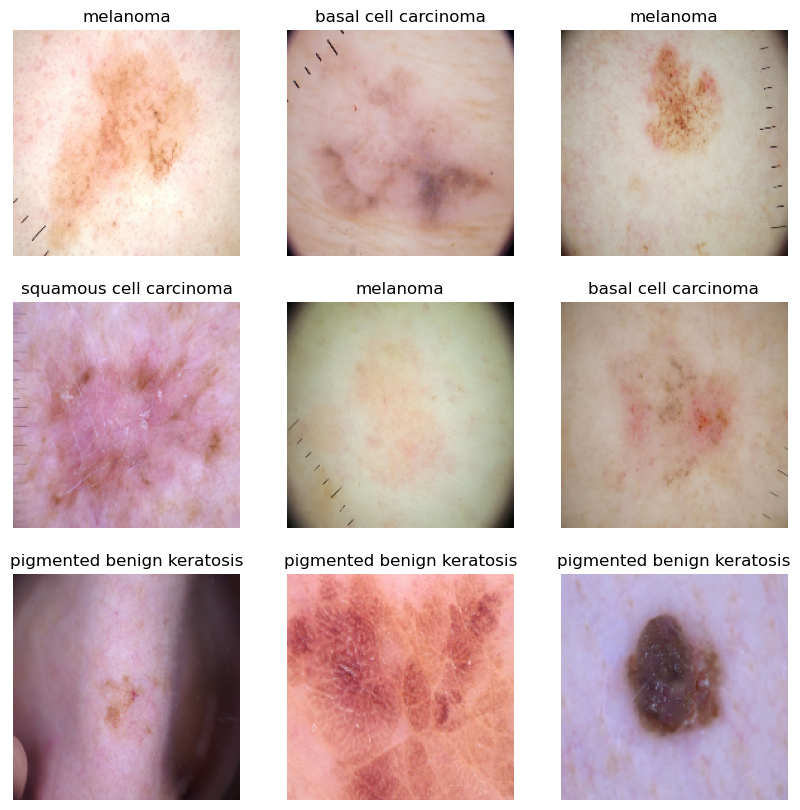

In [18]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

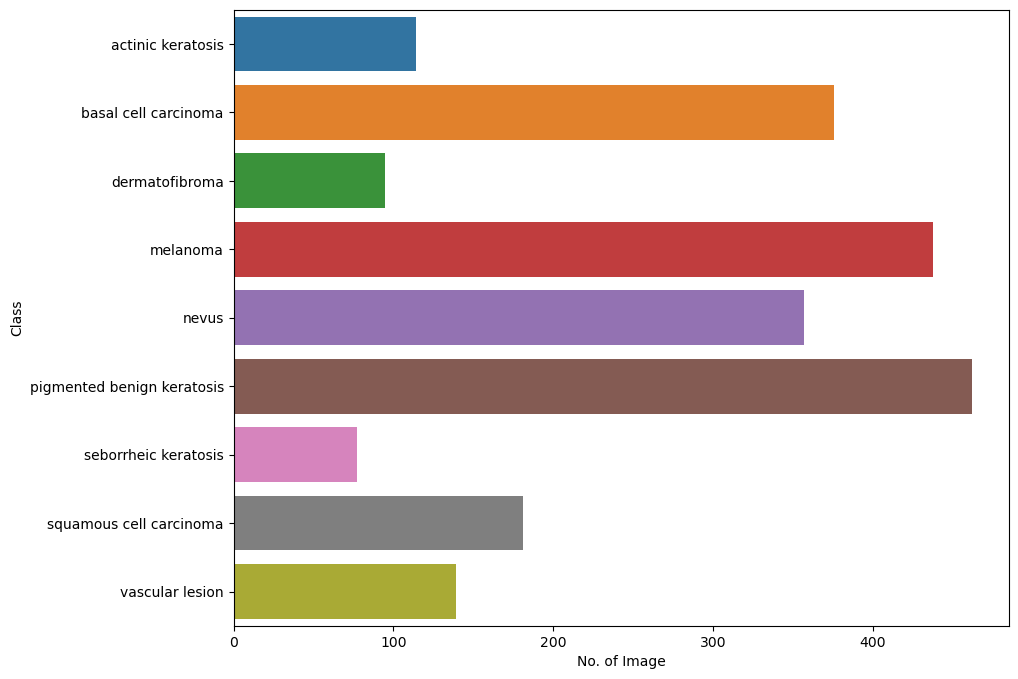

In [21]:

#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)      

### Compiling the model

In [23]:
## Your code goes here
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs 
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 46s 3s/step - loss: 1.4138 - accuracy: 0.4315 - val_loss: 1.3601 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 38s 3s/step - loss: 0.9266 - accuracy: 0.5517 - val_loss: 1.2853 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 37s 3s/step - loss: 0.7943 - accuracy: 0.6124 - val_loss: 1.5808 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - 37s 3s/step - loss: 0.6799 - accuracy: 0.6730 - val_loss: 1.3248 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 37s 3s/step - loss: 0.7075 - accuracy: 0.6539 - val_loss: 1.5333 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - 38s 3s/step - loss: 0.6815 - accuracy: 0.6584 - val_loss: 1.4212 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/20
14/14 [==============================] - 38s 3s/step - loss: 0.6660 - a

### Visualizing the results

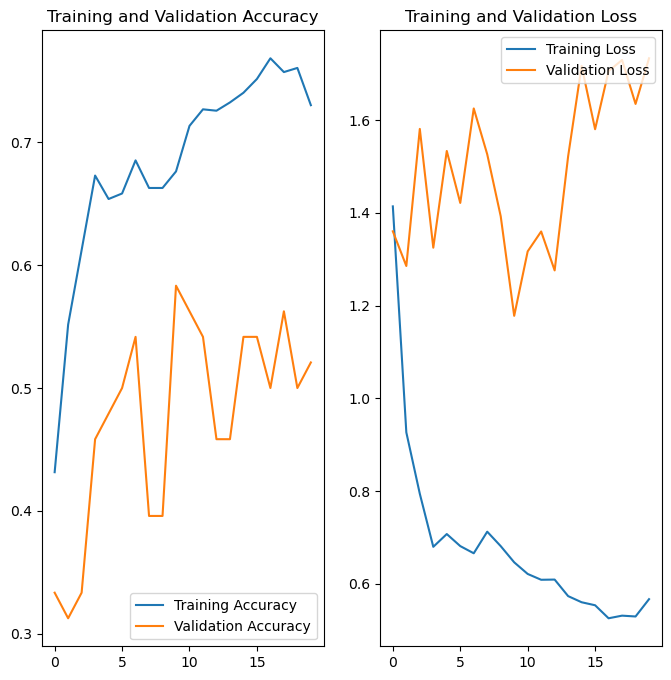

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- Now the model has improved the efficency 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
#### - Which classes dominate the data in terms proportionate number of samples?


- seborrheic keratosis is Least number of samples
- pigmented benign keratosis	class dominate

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    print(i)
    print(path_to_training_dataset+i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x242D241BBB0>: 100%|█| 500/500 [00:03<00:


basal cell carcinoma
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x242D24667D0>: 100%|█| 500/500 [00:09<00:00, 51.35 Samples/


dermatofibroma
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x242D26980A0>: 100%|█| 500/500 [00:09<00:00, 55.18 Samples/


melanoma
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x242D22F4310>: 100%|█| 500/500 [00:29<00


nevus
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x242D2253EE0>: 100%|█| 500/500 [00:28<0


pigmented benign keratosis
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x242D22F43D0>: 100%|█| 500/500 [00:06<00:00, 76.62 Samples/


seborrheic keratosis
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x242D227C970>: 100%|█| 500/500 [00:15<00:00, 33.11 Samples


squamous cell carcinoma
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x242C1377C70>: 100%|█| 500/500 [00:08<00:00, 62.23 Samples/


vascular lesion
C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to C:/Users/ajayj/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x242C10004F0>: 100%|█| 500/500 [00:07<00:00, 67.17 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_38c27ae2-e560-4fc6-a834-38703278944e.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_44c5b527-8f5c-4087-94df-6f2ef5b307cf.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c04d8e9c-ccc1-4e8f-9e69-a175e81a4d34.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1ebedd16-6caa-4730-a164-9deda922723b.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_95d11dc5-3e6e-44a8-ae8d-48a3ca9a18ab.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_b47cd02a-3648-414c-9d44-4ae88fe1df6c.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_06a77489-66f3-4726-80ab-655d66b4d314.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_327be62c-4498-4a05-be3f-f06cc9e7cfef.jpg',
 'Train\\actinic

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [35]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train=pathlib.Path("Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here
#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### **Todo:**  Train your model

In [41]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/50
14/14 [==============================] - 42s 3s/step - loss: 1.2780 - accuracy: 0.4393 - val_loss: 1.5851 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 45s 3s/step - loss: 0.9437 - accuracy: 0.5236 - val_loss: 1.6748 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 51s 4s/step - loss: 0.8580 - accuracy: 0.5865 - val_loss: 1.2745 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 44s 3s/step - loss: 0.8081 - accuracy: 0.6169 - val_loss: 1.2058 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 39s 3s/step - loss: 0.7225 - accuracy: 0.6697 - val_loss: 1.5085 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.6663
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 37s 3s/step - loss: 0.74

14/14 [==============================] - 49s 4s/step - loss: 0.5336 - accuracy: 0.7798 - val_loss: 1.5126 - val_accuracy: 0.5833 - lr: 1.0000e-05
Epoch 47/50
14/14 [==============================] - 49s 4s/step - loss: 0.5428 - accuracy: 0.7607 - val_loss: 1.6075 - val_accuracy: 0.5417 - lr: 1.0000e-05
Epoch 48/50
14/14 [==============================] - 49s 4s/step - loss: 0.5482 - accuracy: 0.7652 - val_loss: 1.6213 - val_accuracy: 0.5417 - lr: 1.0000e-05
Epoch 49/50
14/14 [==============================] - 48s 3s/step - loss: 0.5485 - accuracy: 0.7494 - val_loss: 1.5919 - val_accuracy: 0.5417 - lr: 1.0000e-05
Epoch 50/50
14/14 [==============================] - 48s 3s/step - loss: 0.5484 - accuracy: 0.7584 - val_loss: 1.5331 - val_accuracy: 0.5208 - lr: 1.0000e-05


#### **Todo:**  Visualize the model results

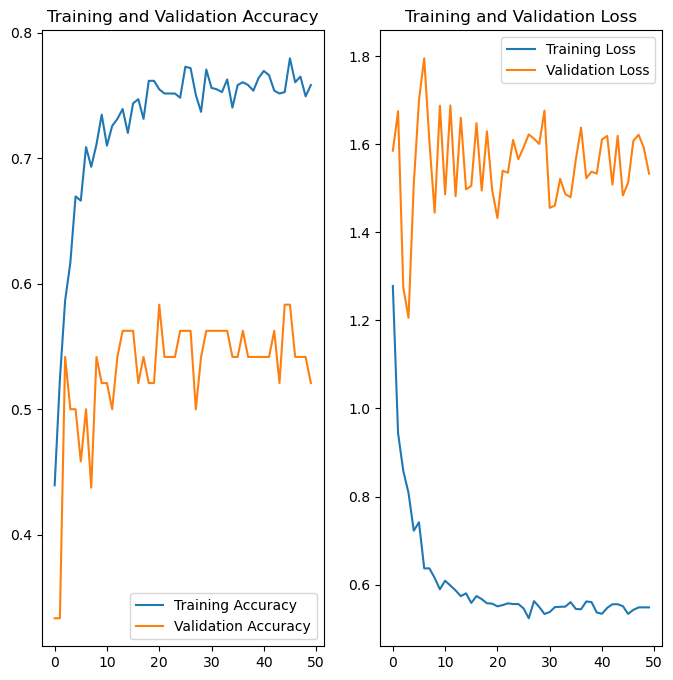

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit